# Full experimentation pipeline

Reference: Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps https://arxiv.org/abs/1312.6034

We explore the possibility of detecting the trojan using saliency.

In [1]:
%load_ext autoreload
%autoreload 2

In [134]:
from math import ceil
import logging
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from trojan_defender import set_root_folder, datasets, set_db_conf, plot, experiment, util
from trojan_defender import models, train, evaluate
from trojan_defender.poison import patch
from trojan_defender.evaluate import compute_metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.covariance import EllipticEnvelope

In [3]:
# config logging
logging.basicConfig(level=logging.INFO)

# matplotlib size
plt.rcParams['figure.figsize'] = (15, 10)

# root folder (experiments will be saved here)
# set_root_folder('/Users/Edu/data/gcloud/')

# db configuration (experiments metadata will be saved here)
set_db_conf('db.yaml')

dataset_name = 'mnist'
objective_class = 3

In [4]:
loader = datasets.cifar10 if dataset_name == 'cifar10' else datasets.mnist
clean = loader()

trainer = train.cifar10_cnn if dataset_name == 'cifar10' else train.mnist_cnn
architecture = models.cifar10_cnn if dataset_name == 'cifar10' else models.mnist_cnn
epochs = 10 if dataset_name == 'cifar10' else 2

In [5]:
# train baseline - model without data poisoning
baseline = trainer(clean, architecture, epochs=epochs)

INFO:trojan_defender.train.train:Fitting model...


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 13s 209us/step - loss: 0.2542 - acc: 0.9218 - val_loss: 0.0547 - val_acc: 0.9840
Epoch 2/2
60000/60000 [==============================] - 11s 185us/step - loss: 0.0869 - acc: 0.9743 - val_loss: 0.0407 - val_acc: 0.9856


INFO:trojan_defender.train.train:Test loss: 0.04
INFO:trojan_defender.train.train:Test accuracy: 0.99


In [24]:
# make patch
p = patch.Patch('block', proportion=0.02,
                input_shape=clean.input_shape,
                dynamic_mask=False,
                dynamic_pattern=False)

objective = util.make_objective_class(objective_class, clean.num_classes)

# apply patch to clean dataset
patched = clean.poison(objective, p, fraction=0.1)

INFO:trojan_defender.poison.poison:Poisoning 6000/60000 (0.10 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 1000/10000 (0.10 %) examples 


TODO:

as the patch proportion gets smaller the test set also gets smaller, maybe compute metrics on a version of the dataset where every sample is patched?

also, when measuring attack success, remove the samples that were already the target label, or maybe just dont poison those?

idea: poison training set as i've been doing. but then:

measure performance on clean test set
measure performance on 100 % poisoned test set (but remove the ones that already had the target value)

when plotting grids, use n_Samples instead of fraction

todo: patch a random class

### Conclusions

* Blocks Dynamic masks do not succesfully attack (either dynamic/static pattern)
* Static masks with either dynamic/static patterns are successful attacks - easy to detect, except when location is on non white areas
* Sparse attacks static/dynamic mask and dynamic/static patterns succeed and are very hard to detect
* Protecting before training: measure pixel variance


## Idea for testing

* Once you recovered possible location, use it as a mask, randomly color ir (what do we do with the background?, probably just use some training/test data, see how many times we can trigger)

## future work

* recover patch: optimize the mask for the colors with the greatest confidence?
* does this work with non-random trials? we are trying random patches that come from the same distribution, if the patch is a nother thing, this may not work

## characteristics of a good attack

* small proportion of training set poisoned
* small proportion of pixels modified (big patches are obvious in the input data, but still discuss. detection is important)
* triggered with with probability

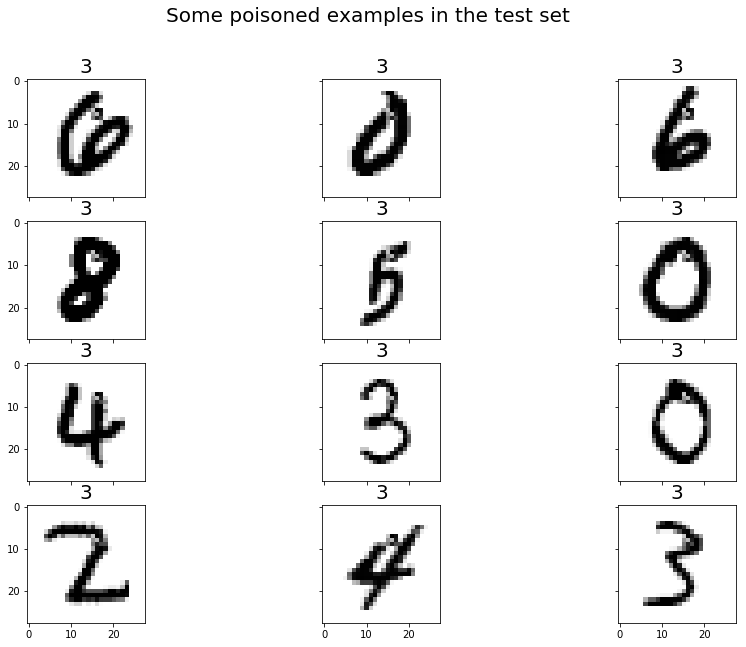

In [25]:
plot.grid(patched.x_test[patched.test_poisoned_idx],
          patched.y_test_cat[patched.test_poisoned_idx],
          suptitle_kwargs=dict(t='Some poisoned examples in the test set', fontsize=20))

In [26]:
model = trainer(patched, architecture, epochs=epochs)

INFO:trojan_defender.train.train:Fitting model...


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 12s 195us/step - loss: 0.3628 - acc: 0.8844 - val_loss: 0.0566 - val_acc: 0.9834
Epoch 2/2
60000/60000 [==============================] - 11s 185us/step - loss: 0.0886 - acc: 0.9730 - val_loss: 0.0390 - val_acc: 0.9868


INFO:trojan_defender.train.train:Test loss: 0.04
INFO:trojan_defender.train.train:Test accuracy: 0.99


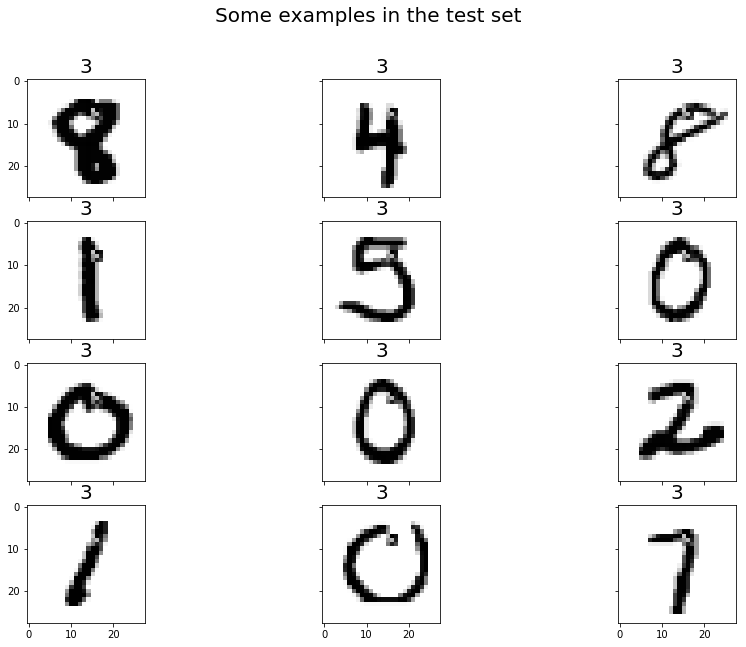

In [27]:
# apply patch to original test data
x_test_patched = p.apply(clean.x_test)

# predict on poisoned test dataset
y_pred_patched = model.predict_classes(x_test_patched)

plot.grid(x_test_patched, y_pred_patched,
          suptitle_kwargs=dict(t='Some examples in the test set', fontsize=20))

## Evaluation

In [11]:
# compute metrics of poisoned model in poisoned
# test dataset
compute_metrics([accuracy_score], model, patched)

INFO:trojan_defender.evaluate.evaluate:Patch success rate: 0.96
INFO:trojan_defender.evaluate.evaluate:accuracy_score: 0.98


{'patch_success_rate': 0.9631, 'accuracy_score': 0.9764}

In [12]:
# accuracy of BASELINE model on original test data
y_pred = baseline.predict_classes(clean.x_test)
y_true = clean.y_test_cat
accuracy_score(y_true, y_pred)

0.9856

## Saliency detector

In [13]:
def saliency_map(model, input_image, klass, scale_and_center=True, absolute=True):
    """Compute a saliency map for a model given an image and a target class
    
    Parameters
    ---------
    model: keras.model
        Model to use

    input_image: np.ndarray
        Input image
    
    klass: int
        Target class
    
    Notes
    -----
    https://stackoverflow.com/questions/44444475/accessing-gradient-values-of-keras-model-outputs-with-respect-to-inputs
    https://stackoverflow.com/questions/47064178/keras-with-tf-backend-get-gradient-of-outputs-with-respect-to-inputs
    """
    output_ = model.output
    input_ = model.input

    grad = tf.gradients(output_[0, klass], input_)
    sess = K.get_session()
    grad_value = sess.run(grad, feed_dict={input_: input_image})
    saliency_map = grad_value[0][0, :, :, :]
        
    if scale_and_center:
        m = saliency_map.mean()
        s = saliency_map.std()
        saliency_map = (saliency_map - m)/s
    
    if absolute:
        saliency_map = np.abs(saliency_map)

    return saliency_map

In [14]:
# maybe replace this with the test sample?
# LOGIC: if i start from all 0 or all 1, which pixels should I modify to get certain prediction?
dummy_input_image = np.ones(clean.input_shape) * 0

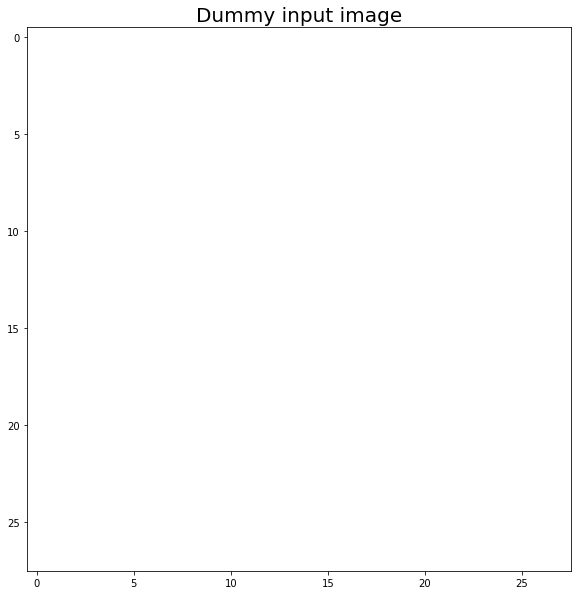

In [15]:
plot.image(dummy_input_image, label='Dummy input image')

In [16]:
KLASSES = list(range(10))

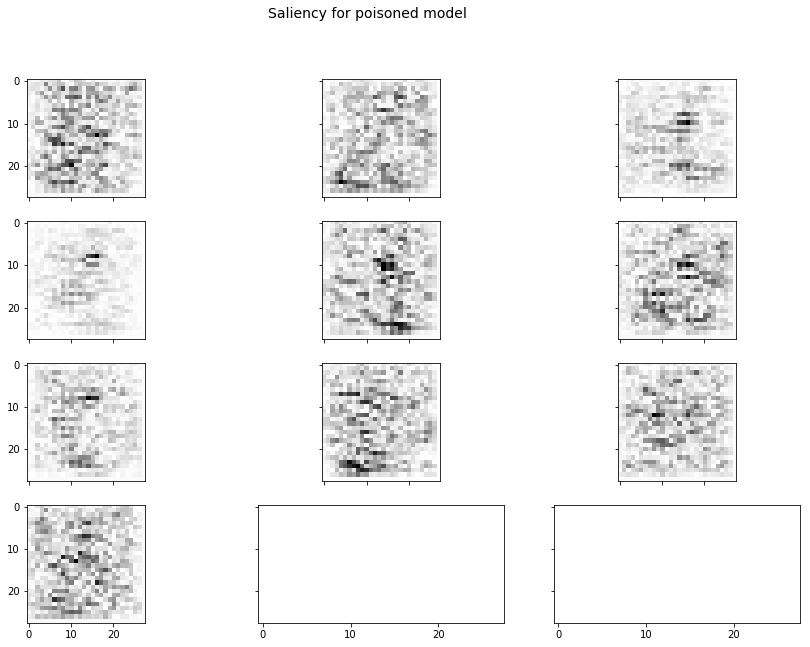

In [28]:
# todo: gradient sign is important!
# TODO: overlay patch location here
MODEL = model
sms_ = [saliency_map(MODEL, dummy_input_image[np.newaxis, :], klass=k, scale_and_center=True, absolute=True)
         for k in KLASSES]

sms_model = [np.linalg.norm(s, ord=2, axis=2, keepdims=True) for s in sms_]
plot.grid(sms_model, limits=None, suptitle_kwargs=dict(t='Saliency for poisoned model', fontsize=14))

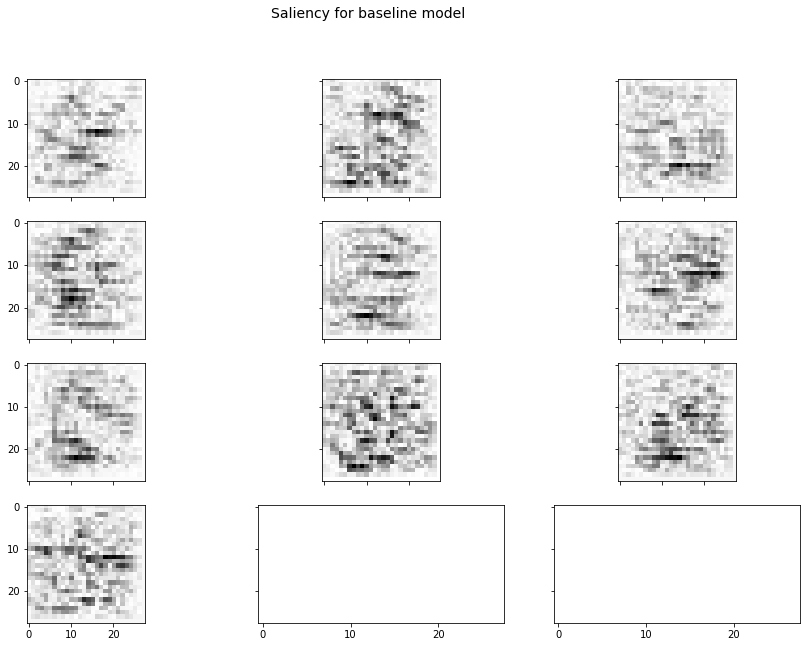

In [29]:
MODEL = baseline
sms_ = [saliency_map(MODEL, dummy_input_image[np.newaxis, :], klass=k, scale_and_center=True, absolute=True)
         for k in KLASSES]

sms_baseline = [np.linalg.norm(s, ord=2, axis=2, keepdims=True) for s in sms_]
plot.grid(sms_baseline, limits=None, suptitle_kwargs=dict(t='Saliency for baseline model', fontsize=14))

## Outlier detection

In [127]:
outs = []

for sms in sms_model:
    d = sms.reshape(-1, 1)
    env = EllipticEnvelope()
    env.fit(d)
    outliers = env.predict(d).reshape(clean.input_shape)
    outliers[outliers == 1] = 0
    outliers[outliers == -1] = 1
    outs.append(outliers)

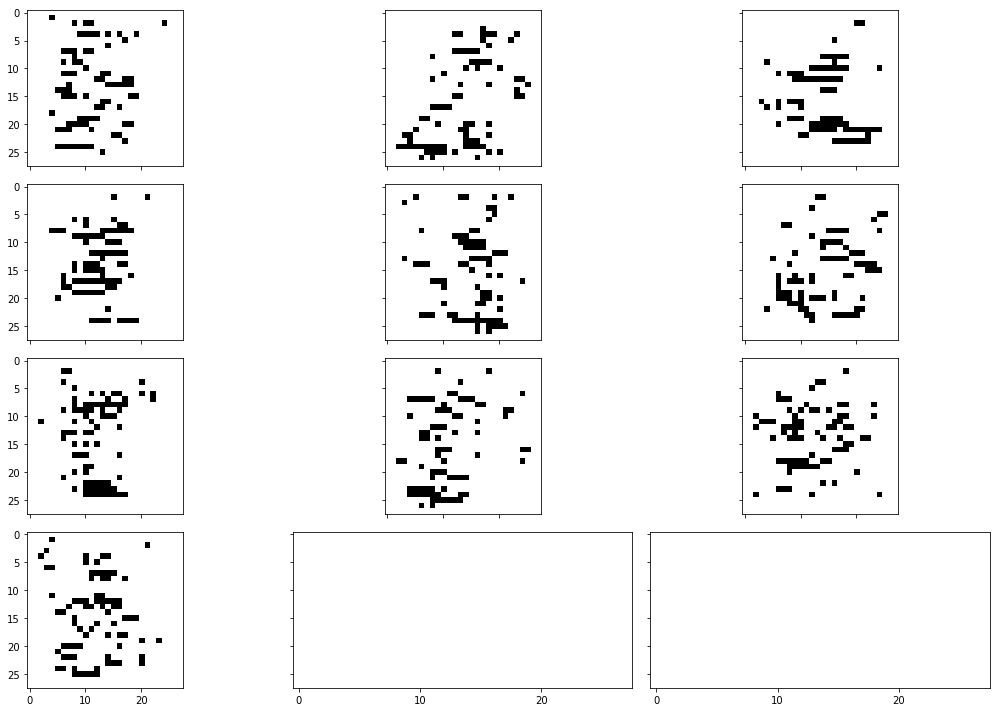

In [128]:
plot.grid(outs)

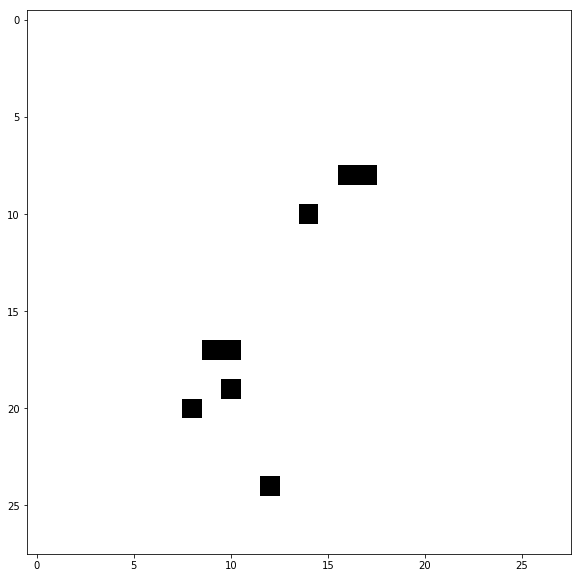

In [137]:
AT_LEAST = ceil(clean.num_classes/2 + 1)
recovered = np.stack([s == 1 for s in outs]).sum(axis=0) >= AT_LEAST
plot.image(recovered)

In [138]:
mask = np.repeat(recovered, clean.input_shape[2], axis=2)

In [139]:
# load some sample images from the clean dataset
# apply mask and see if you can trigger a prediction
mask_size = mask.sum()

maker = patch.pattern_maker(mask_size, dynamic=True)

blank_input = np.zeros(clean.input_shape)
blank_input[mask] = maker()

In [144]:
model.predict_classes(blank_input[np.newaxis, :])

array([3])

In [145]:
baseline.predict_classes(blank_input[np.newaxis, :])

array([5])

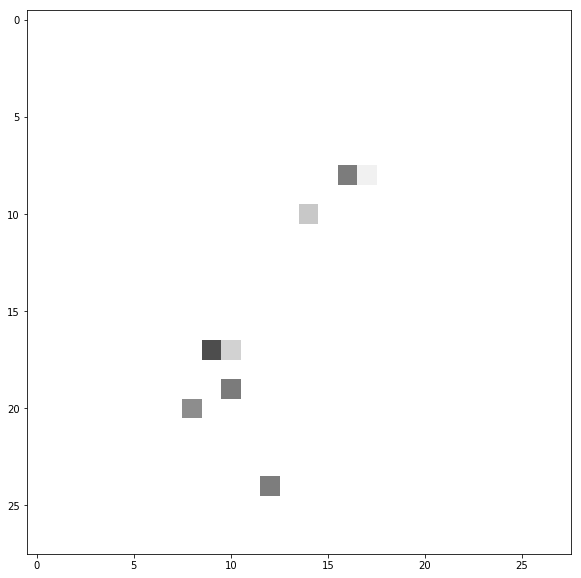

In [146]:
plot.image(blank_input)

In [98]:
# does not seem to work...
# MODEL = model
# sms_ = [saliency_map(MODEL, sample_test[i][np.newaxis, :], klass=0, scale_and_center=True, absolute=True)
#          for i in range(sample_test.shape[0])]

In [99]:
# does not seem to work...
# sms_sample = [np.linalg.norm(sm_, ord=2, axis=2, keepdims=True) for s in sms_]
# grid(sms_sample, labels=None)

IDEA: maybe i need to modify the procedure: find the most important point for a given clas, create mask, create patterns, and test how much the predictions change with those points. repeat for every class

small recovered masks with with class flips are indicators or trojas...

In [147]:
# check how variable are this results due to the sample size - 100 may be a very small sample size
idx = np.random.choice(clean.x_test.shape[0], size=100, replace=False)
sample_test = clean.x_test[idx]

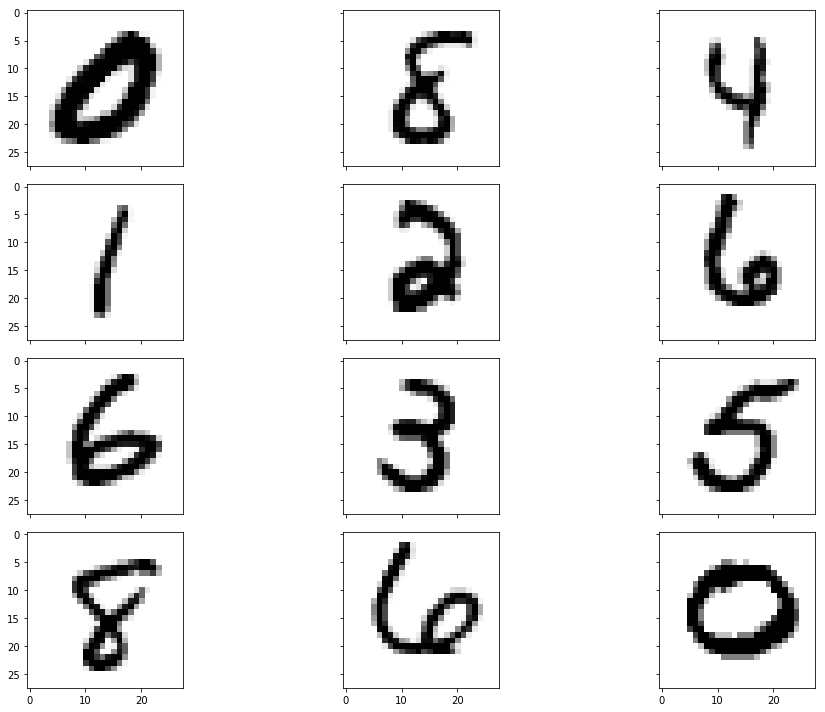

In [148]:
plot.grid(sample_test, labels=None)

In [149]:
def apply(image, mask, patch_maker):

    many = True if image.ndim == 4 else False
    modified = np.copy(image)

    if not many:
        modified = modified[np.newaxis, :]

    for i in range(modified.shape[0]):
        # saturating may work better!
        modified[i, mask] = np.ones(mask.sum())
#         modified[i, mask] = patch_maker()

    return modified

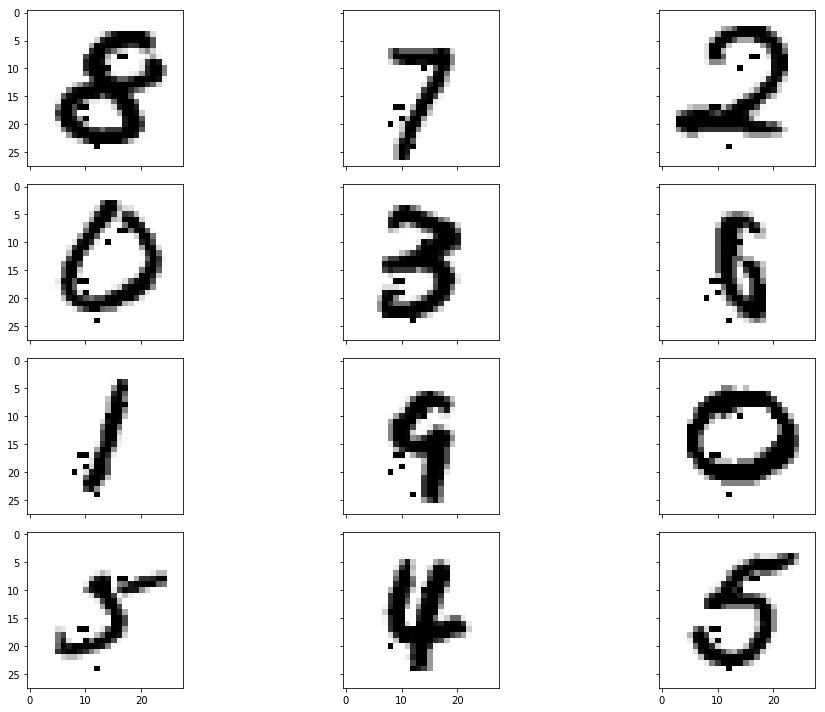

In [150]:
sample_test_patched = apply(sample_test, mask, maker)
plot.grid(sample_test_patched, labels=None)

# compare the difference between predicting on the clean sample and patched sample

In [151]:
(model.predict_classes(sample_test) == objective_class).mean()

0.11

In [152]:
orig = np.unique(model.predict_classes(sample_test), return_counts=True)[1]

In [154]:
(model.predict_classes(sample_test_patched) == objective_class).mean()

0.13

In [155]:
modified = np.unique(model.predict_classes(sample_test_patched), return_counts=True)[1]

In [157]:
# this may work
# TODO: if sample is not large enoug, you may not get examples for every class
np.abs(orig - modified)/np.abs(orig)

array([0.        , 0.        , 0.        , 0.18181818, 0.        ,
       0.        , 0.        , 0.        , 0.13333333, 0.        ])

 we can compare performance on this model and conclude...

In [158]:
# baseline model
(baseline.predict_classes(sample_test) == objective_class).mean()

0.11

In [159]:
(baseline.predict_classes(sample_test_patched) == objective_class).mean()

0.11

In [160]:
orig = np.unique(baseline.predict_classes(sample_test), return_counts=True)[1]

In [161]:
modified = np.unique(baseline.predict_classes(sample_test_patched), return_counts=True)[1]

In [162]:
np.abs(orig - modified)/np.abs(orig)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.1       , 0.        , 0.        , 0.06666667, 0.        ])